In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.utils.data

# !pip install d2l==1.0.3

# Logistic Regression on MNIST

In [27]:
from torchvision.datasets import MNIST

mnist_train = MNIST(root=".",      # where on the disk to store the data
                    download=True, # download the data if it does not already exist
                    train=True)    # use the training set (rather than the test set)

In [28]:
print(mnist_train[0]) # a tuple consisting of the image, and the label (5)

(<PIL.Image.Image image mode=L size=28x28 at 0x7934642588B0>, 5)


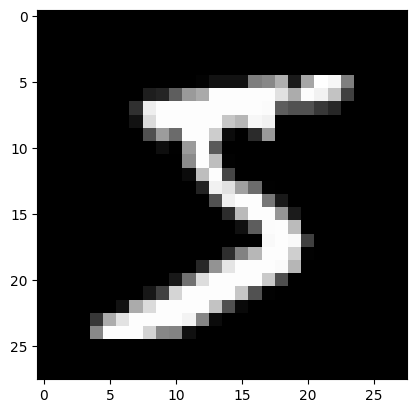

In [29]:
plt.imshow(mnist_train[0][0], cmap='gray') # display the image

In [30]:
import torchvision.transforms as transforms

mnist_data = MNIST(root=".",      # where on the disk to store the data
                   download=True, # download the data if it does not already exist
                   train=True,    # use the canonical training set (rather than the test set)
                   transform=transforms.ToTensor()) # transforms the images into PyTorch tensors
mnist_data = list(mnist_data)#[:5000]


In [31]:
print(len(mnist_data))

60000


In [32]:
total_size = len(mnist_data)
set_1_size = int(0.7 * total_size)
set_2_size = int(0.1 * total_size)
set_3_size = int(0.2 * total_size)


train_data = mnist_data[:set_1_size]
val_data   = mnist_data[set_1_size:set_1_size+set_2_size]
test_data  = mnist_data[set_1_size+set_2_size:]

In [33]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Softmax(dim=1)
)

print(model[0].weight) # the weight parameter, initialized to random values
print(model[0].bias)   # the bias parameter, initialized to random values

Parameter containing:
tensor([[ 0.0252, -0.0285, -0.0062,  ..., -0.0143, -0.0010, -0.0201],
        [-0.0073,  0.0299, -0.0287,  ...,  0.0065,  0.0240,  0.0333],
        [-0.0005, -0.0289,  0.0231,  ...,  0.0148, -0.0211,  0.0057],
        ...,
        [ 0.0047,  0.0278,  0.0284,  ..., -0.0091, -0.0210, -0.0189],
        [ 0.0312, -0.0007,  0.0196,  ..., -0.0141,  0.0293,  0.0220],
        [-0.0348,  0.0167, -0.0143,  ...,  0.0029,  0.0172,  0.0004]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0164,  0.0154,  0.0006, -0.0131,  0.0073,  0.0298, -0.0035, -0.0347,
         0.0279,  0.0204], requires_grad=True)


In [50]:
def accuracy(model, dataset):
    """
    Same signature as the `accuracy_basic()` function, but we will use a DataLoader and process
    100 images at a time
    """
    correct, total = 0, 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=100)
    for X, t in loader:
        X = X.to(device)
        t = t.to(device)
        z = model(X.reshape(-1,784)) # TODO: use a single call to `model()` here as before
        pred =  torch.argmax(z,axis=1)# TODO: `pred` should have the same shape as `t`
        correct += int(torch.sum(t == pred))# TODO: update `correct` and `total`
        total += t.shape[0]
    return torch.tensor(correct / total)

In [51]:
criterion = nn.CrossEntropyLoss()

In [60]:
from torch.optim import Optimizer

class MyAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999),lambdas=(0.84,0.84)):
        super().__init__(params, lr=lr, betas=betas)
        self.lambdas = lambdas

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients")

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]
                lambda1,lambda2 = self.lambdas[0], self.lambdas[1]
                beta_t = [beta1 * np.exp(-lambda1 * np.linalg.norm(p.grad, ord=np.inf)),beta2 * np.exp(-lambda2 * np.linalg.norm(p.grad, ord=np.inf))]
                state["step"] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta_t[0]).add_(1 - beta_t[0], p.grad)
                exp_avg_sq.mul_(beta_t[1]).addcmul_(1 - beta_t[1], p.grad, p.grad)

                exp_avg_sq = torch.max(state["exp_avg_sq"] , exp_avg_sq)
                print("torch max is fine")

                denom = exp_avg_sq.sqrt().add_(group["eps"])

                bias_correction1 = 1 - beta_t[0] ** state["step"]
                bias_correction2 = 1 - beta_t[1] ** state["step"]
                learning_rate = group["lr"] #/ (np.sqrt(state["step"]))
                step_size =  learning_rate * np.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)


In [61]:
def train_model(model,
                train_data,
                val_data,
                optimizer_choice = None,
                lambdas = (0.8,0.8),
                betas=(0.9, 0.999),
                learning_rate=0.001,
                batch_size=128,
                num_epochs=5,
                plot_every=5,
                ):
    """
    Train the PyTorch model `model` using the training data `train_data` and the
    corresponding hyperparameters. Report training loss, training accuracy, and
    validation accuracy every `plot_every` iterations.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True) # reshuffle minibatches every epoch


    criterion = nn.CrossEntropyLoss()


    if optimizer_choice == "Adam":
      optimizer = optim.Adam(model.parameters(), # the parameters to optimize
                      lr=0.005)
    elif optimizer_choice == "New_Adam":
      optimizer = MyAdam(model.parameters(), # the parameters to optimize
                      lr=0.005, lambdas = lambdas)
    elif optimizer_choice == "NAdam":
      optimizer = optim.NAdam(model.parameters(), # the parameters to optimize
                      lr=0.005)
    elif optimizer_choice == "RAdam":
      optimizer = optim.RAdam(model.parameters(), # the parameters to optimize
                      lr=0.005)
    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed


    for e in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)
            z = model(images.reshape(-1,784)) # TODO

            loss = criterion(z, labels) # TODO

            loss.backward() # propagate the gradients
            optimizer.step() # update the parameters
            optimizer.zero_grad() # clean up accumualted gradients

            iter_count += 1
            if iter_count % plot_every == 0:
                iters.append(iter_count)
                train_loss.append(float(loss))
                t_acc = accuracy(model, train_data)
                train_acc.append(t_acc)
                v_acc = accuracy(model, val_data)
                val_acc.append(v_acc)
                print(f"Epoch [{e}/{num_epochs - 1}] iter: {iter_count}    training loss: {loss}   training acc: {t_acc}   validation acc: {v_acc}")



    return iters, train_loss, train_acc, val_acc



In [62]:
import torchvision.models as models

model2 = nn.Sequential(
    nn.Linear(784, 10),
    nn.Softmax(dim=1)
)
iters2, train_loss2, train_acc2, val_acc2 = train_model(model2, train_data, val_data,optimizer_choice="New_Adam",lambdas=(0.8,0.8))

model1 = nn.Sequential(
    nn.Linear(784, 10),
    nn.Softmax(dim=1)
)
iters1, train_loss1, train_acc1, val_acc1 = train_model(model1, train_data, val_data,optimizer_choice="Adam")



going to calculate beta_t


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
model3 = nn.Sequential(
    nn.Linear(784, 10),
    nn.Softmax(dim=1)
)
iters3, train_loss3, train_acc3, val_acc3 = train_model(model3, train_data, val_data,optimizer_choice="NAdam")

model4 = nn.Sequential(
    nn.Linear(784, 10),
    nn.Softmax(dim=1)
)
iters4, train_loss4, train_acc4, val_acc4 = train_model(model4, train_data, val_data,optimizer_choice="RAdam")

In [ ]:
plt.figure(figsize=(11, 4), dpi=200)

plt.subplot(1, 2, 1)  # (rows, columns, plot_number)
plt.plot(iters1[:len(train_loss1)], train_loss1, label="Adam", lw=1)
plt.plot(iters2[:len(train_loss2)], train_loss2, label="Our algorithm", lw=1)
plt.plot(iters3[:len(train_loss3)], train_loss3, label="NAdam", lw=1, alpha=0.3)
plt.plot(iters4[:len(train_loss4)], train_loss4, label="RAdam", lw=1, alpha=0.3)
plt.title("Loss over iterations with MNIST logistic regression")
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)  # (rows, columns, plot_number)
plt.plot(iters1[:len(train_acc1)], train_acc1, label="Adam train", lw=1)
plt.plot(iters1[:len(val_acc1)], val_acc1, label="Adam val.", lw=1)
plt.plot(iters2[:len(train_acc2)], train_acc2, label="Our algorithm train", lw=1)
plt.plot(iters2[:len(val_acc2)], val_acc2, label="Our algorithm val.", lw=1)
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.title("Accuracy over iterations with MNIST logistic regression")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()


# Show the plots
plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.show()

# Logistic Regression on IMDB Movie Reviews

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
# Load data
df = pd.read_csv('./drive/MyDrive/imdb_reviews_dataset.csv')
df['type_review'] = df['id'].apply(lambda x: x.split('_')[0])
df_labeled = df[df['type_review'] != 'unsup'].copy()
df_labeled['sentiment'] = df_labeled['type_review'].apply(lambda x: 1 if x == 'pos' else 0)
df_labeled['len_text'] = df_labeled['text'].apply(lambda x: len(x.split()))
display(df_labeled)

,data_type,id,rating,text,type_review,sentiment,len_text
0,train,pos_0,9,Bromwell High is a cartoon comedy. It ran at t...,pos,1,140
1,train,pos_10000,8,Homelessness (or Houselessness as George Carli...,pos,1,428
2,train,pos_10001,10,Brilliant over-acting by Lesley Ann Warren. Be...,pos,1,147
3,train,pos_10002,7,This is easily the most underrated film inn th...,pos,1,124
4,train,pos_10003,8,This is not the typical Mel Brooks film. It wa...,pos,1,120
...,...,...,...,...,...,...,...
99995,test,neg_9998,1,I occasionally let my kids watch this garbage ...,neg,0,108
99996,test,neg_9999,1,When all we have anymore is pretty much realit...,neg,0,163
99997,test,neg_999,3,The basic genre is a thriller intercut with an...,neg,0,268
99998,test,neg_99,3,Four things intrigued me as to this film - fir...,neg,0,126


In [ ]:
data = [(text, sentiment) for text, sentiment in zip(df_labeled['text'], df_labeled['sentiment'])]

# shuffle the data, since the file stores all negative tweets first
import random
random.seed(125)
random.shuffle(data)

total_size = len(data)
set_1_size = int(0.7 * total_size)
set_2_size = int(0.1 * total_size)
set_3_size = int(0.2 * total_size)


train_data_movies = data[:set_1_size]
val_data_movies  = data[set_1_size:set_1_size+set_2_size]
test_data_movies  = data[set_1_size+set_2_size:]

50000

In [ ]:
# Load data
df = pd.read_csv('./drive/MyDrive/imdb_reviews_dataset.csv')
df['type_review'] = df['id'].apply(lambda x: x.split('_')[0])
df_labeled = df[df['type_review'] != 'unsup'].copy()
df_labeled['sentiment'] = df_labeled['type_review'].apply(lambda x: 1 if x == 'pos' else 0)
df_labeled['len_text'] = df_labeled['text'].apply(lambda x: len(x.split()))
VALIDATION_SPLIT = 0.2

# Shuffle and split data into train and test sets
indices = np.arange(df_labeled.shape[0])
np.random.shuffle(indices)
review = df_labeled.iloc[indices]
num_validation_samples = int(VALIDATION_SPLIT * review.shape[0])

In [ ]:
X_train = review.iloc[:-num_validation_samples]['text']
y_train = review.iloc[:-num_validation_samples]['sentiment']
X_val = review.iloc[-num_validation_samples:]['text']
y_val = review.iloc[-num_validation_samples:]['sentiment']

# Define Field for tokenization
TEXT = torchtext.data.Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)

# Process the data using the defined Field
X_train_processed = [torchtext.data.Example.fromlist([text], [('text', TEXT)]) for text in X_train]
X_val_processed = [torchtext.data.Example.fromlist([text], [('text', TEXT)]) for text in X_val]

OSError: [E941] Can't find model 'en'. It looks like you're trying to load a model from a shortcut, which is obsolete as of spaCy v3.0. To load the model, use its full name instead:

nlp = spacy.load("en_core_web_sm")

For more details on the available models, see the models directory: https://spacy.io/models and if you want to create a blank model, use spacy.blank: nlp = spacy.blank("en")

In [ ]:
VALIDATION_SPLIT = 0.2

indices = np.arange(df_labeled.shape[0])
np.random.shuffle(indices)
review = df_labeled.iloc[indices]
num_validation_samples = int(VALIDATION_SPLIT * review.shape[0])

X_train = review.iloc[:-num_validation_samples]['text'].values
y_train = review.iloc[:-num_validation_samples]['sentiment'].values
X_test = review.iloc[-num_validation_samples:]['text'].values
y_test = review.iloc[-num_validation_samples:]['sentiment'].values

In [ ]:
len_text_info = df_labeled['len_text'].describe()
max_length = int(len_text_info['mean'] + 2 * len_text_info['std'])

In [ ]:
def split_long_texts(text_tokens, labels):
    _text_tokens = []
    _labels = []
    for text, label in zip(text_tokens, labels):
        text_size = len(text) // max_length
        text_res = len(text) % max_length

        for i in range(text_size):
            _text_tokens.append(text[i: i + max_length])
            _labels.append(label)

        if text_res > 0.5 * max_length or text_size == 0:
            _text_tokens.append(text[text_size * max_length:])
            _labels.append(label)
    return _text_tokens, np.array(_labels)

tokenizer_obj = Tokenizer()
total_reviews = np.hstack((X_train, X_test))
tokenizer_obj.fit_on_texts(total_reviews)

vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)

X_train_tokens, y_train = split_long_texts(X_train_tokens, y_train)
X_test_tokens, y_test = split_long_texts(X_test_tokens, y_test)

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')


# Multi-layer Neural Network on MNIST

In [ ]:
model11 = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),  # Add ReLU activation
    nn.Dropout(p=0.5),
    nn.Linear(1000, 1000),
    nn.ReLU(),  # Add ReLU activation
    nn.Dropout(p=0.5),
    nn.Linear(1000, 10),
    nn.Softmax(dim=1)
)
iters11, train_loss11, train_acc11, val_acc11 = train_model(model11, train_data, val_data, optimizer_choice="New_Adam", lambdas=(0.8,0.8))

model22 = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),  # Add ReLU activation
    nn.Dropout(p=0.5),

    nn.Linear(1000, 1000),
    nn.ReLU(),  # Add ReLU activation
    nn.Dropout(p=0.5),
    nn.Linear(1000, 10),
    nn.Softmax(dim=1)
)
iters22, train_loss22, train_acc22, val_acc22 = train_model(model22, train_data, val_data, optimizer_choice="Adam")


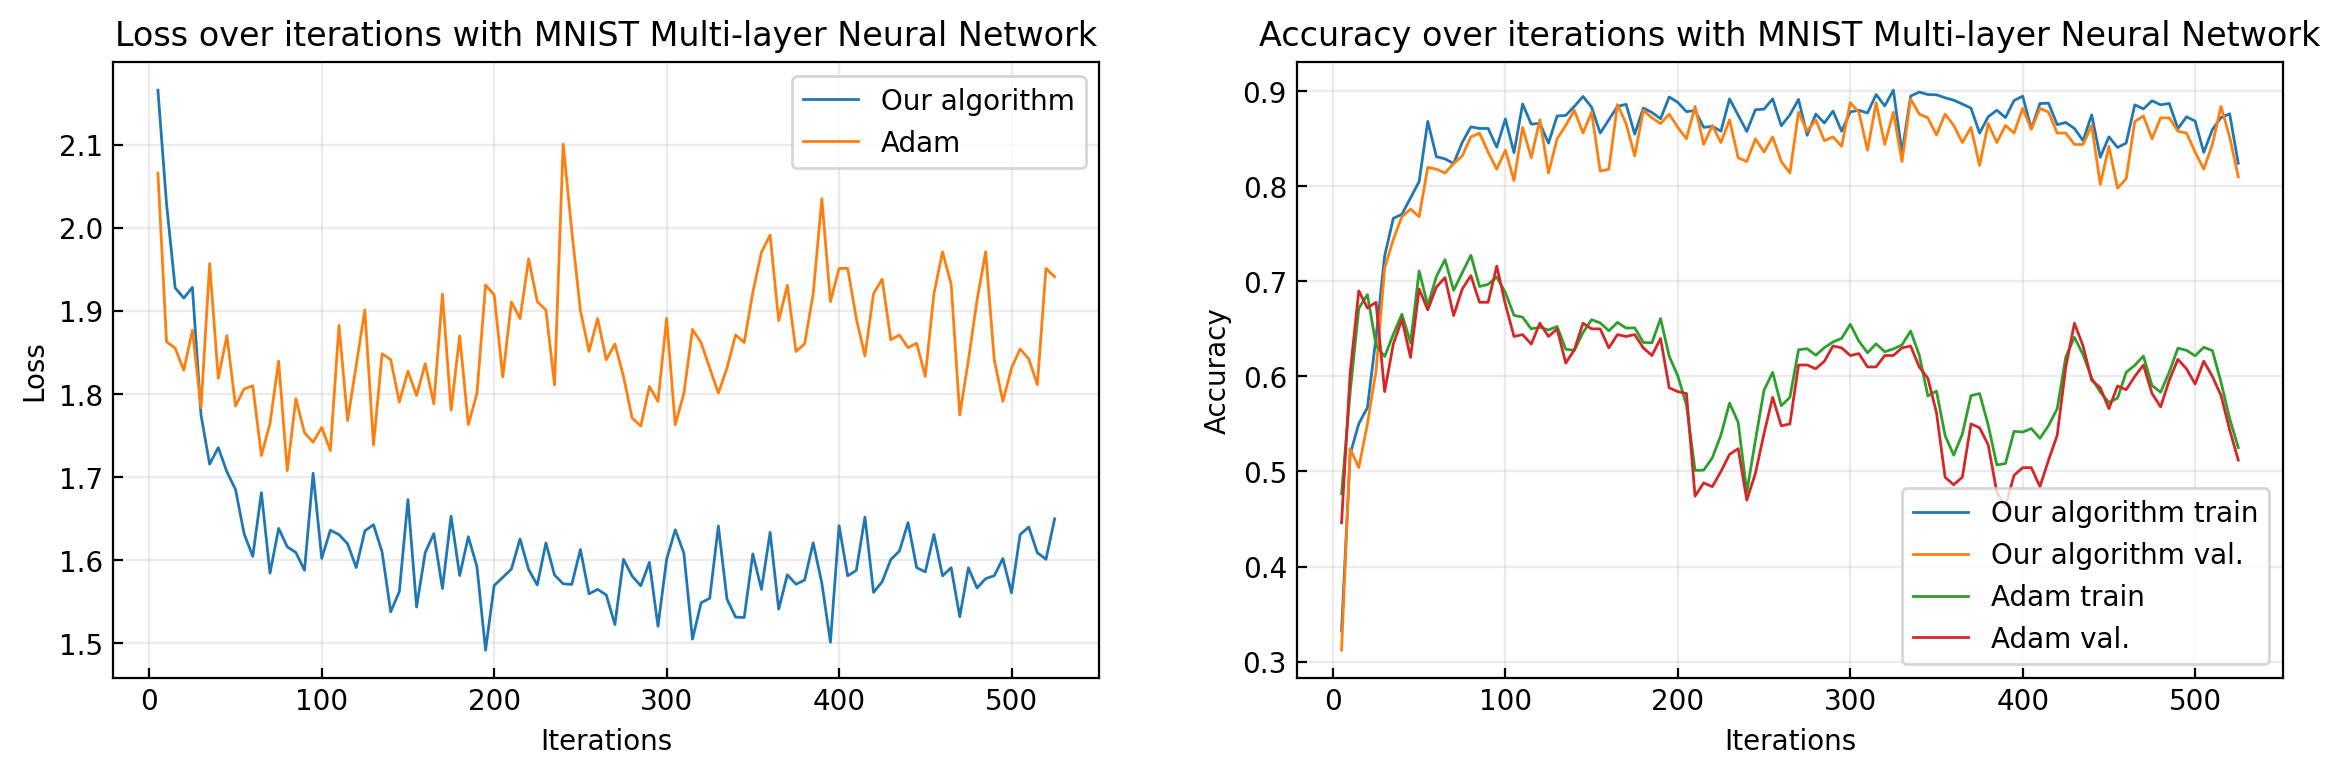

In [ ]:
plt.figure(figsize=(14, 4), dpi=200)

plt.subplot(1, 2, 1)  # (rows, columns, plot_number)
plt.plot(iters11[:len(train_loss11)], train_loss11, label="Our algorithm", lw=1)
plt.plot(iters22[:len(train_loss22)], train_loss22, label="Adam", lw=1)
# plt.plot(iters3[:len(train_loss3)], train_loss3, label="NAdam", lw=1, alpha=0.3)
# plt.plot(iters4[:len(train_loss4)], train_loss4, label="RAdam", lw=1, alpha=0.3)
plt.title("Loss over iterations with MNIST Multi-layer Neural Network")
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)  # (rows, columns, plot_number)
plt.plot(iters11[:len(train_acc11)], train_acc11, label="Our algorithm train", lw=1)
plt.plot(iters11[:len(val_acc11)], val_acc11, label="Our algorithm val.", lw=1)
plt.plot(iters22[:len(train_acc22)], train_acc22, label="Adam train", lw=1)
plt.plot(iters22[:len(val_acc22)], val_acc22, label="Adam val.", lw=1)
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.title("Accuracy over iterations with MNIST Multi-layer Neural Network")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()

# Grid Search


In [ ]:
gridsearch = {}
loss = 1000
for lam1 in [0.8, 0.82,0.84,0.86,0.88]:
    for lam2 in [0.8, 0.82,0.84,0.86,0.88]:


      modelname = f"beta1: {lam1}, beta2: {lam2}"
      print(f"========={modelname}")


      m = nn.Linear(784, 10)
      iters, train_loss, train_acc, val_acc = train_model(m, train_data, val_data, optimizer_choice="New_Adam", lambdas = (lam1,lam2))

      metrics = {
          "acc_train": train_acc[-1],
          "acc_val":  val_acc[-1],
          "train_loss": train_loss[-1]
      }
      gridsearch[modelname] = metrics
      print(f'Accuracy (train):{metrics["acc_train"]} (val):{metrics["acc_val"]} ')
      print(f'Loss (train):{metrics["train_loss"]}')
      if train_loss[-1] < loss:
        loss = train_loss[-1]
        best = (lam1,lam2)


print(best)

=========beta1: 0.8, beta2: 0.8
Accuracy (train):0.9602857142857143 (val):0.906 
Loss (train):0.13395299017429352
=========beta1: 0.8, beta2: 0.82
Accuracy (train):0.9597142857142857 (val):0.904 
Loss (train):0.13145765662193298
=========beta1: 0.8, beta2: 0.84
Accuracy (train):0.9585714285714285 (val):0.924 
Loss (train):0.26225903630256653
=========beta1: 0.8, beta2: 0.86
Accuracy (train):0.9557142857142857 (val):0.91 
Loss (train):0.20832225680351257
=========beta1: 0.8, beta2: 0.88
Accuracy (train):0.9568571428571429 (val):0.91 
Loss (train):0.18326309323310852
=========beta1: 0.82, beta2: 0.8
Accuracy (train):0.9577142857142857 (val):0.908 
Loss (train):0.12790614366531372
=========beta1: 0.82, beta2: 0.82
Accuracy (train):0.958 (val):0.908 
Loss (train):0.2527298927307129
=========beta1: 0.82, beta2: 0.84
Accuracy (train):0.9577142857142857 (val):0.912 
Loss (train):0.17466478049755096
=========beta1: 0.82, beta2: 0.86
Accuracy (train):0.9594285714285714 (val):0.91 
Loss (train):